In [15]:
import pandas as pd
import numpy as np
import matplotlib
# matplotlib.use('Agg')  
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import os
from sklearn.preprocessing import StandardScaler

plt.style.use('seaborn-v0_8')

def load_nifty50_data():
    """
    Downloads the NSEI daily close price data from Yahoo Finance for the last 12 years.
    Returns:
        pandas.Series: NSEI daily close prices.
    """
    ticker = "^NSEI"  # Ticker for NIFTY 50 index
    data = yf.download(ticker, period="12y")  # Download past 12 years of data
    return data['Close']

def preprocess_data(data):
    """
    Preprocesses the data by applying log transformation and standardization.
    
    Args:
        data (pandas.Series or pandas.DataFrame or numpy.ndarray): The input dataset.
        
    Returns:
        numpy.ndarray: Scaled and preprocessed features.
        StandardScaler: Scaler used to standardize the data.
    """
    # Convert DataFrame or Series to NumPy array
    if isinstance(data, (pd.DataFrame, pd.Series)):
        data = data.values  # Convert to NumPy array

    log_data = np.log(data)  # Log transformation
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(log_data.reshape(-1, 1))

    return data_scaled, scaler

def inverse_transform_predictions(predictions, scaler):
    """
    Inverse transforms the predictions to the original scale using the scaler and log transformation.
    
    Args:
        predictions (numpy.ndarray): Predicted values in the scaled and log-transformed space.
        scaler (StandardScaler): Scaler object used for standardizing the original data.
    
    Returns:
        numpy.ndarray: Predictions transformed back to the original scale.
    """
    # Step 1: Inverse the standardization
    predictions_unscaled = scaler.inverse_transform(predictions)
    
    # Step 2: Exponentiate the data to reverse the log transformation
    original_scale_predictions = np.exp(predictions_unscaled)
    
    return original_scale_predictions

def calculate_returns(data):
    """
    Calculates simple returns from the given data.
    Args:
        data (pandas.Series or numpy.ndarray): The input dataset (e.g., stock prices).
    Returns:
        numpy.ndarray: Simple returns as a percentage.
    """
    returns = (data[1:] - data[:-1]) / data[:-1]   # Simple percentage returns
    return returns


def create_sequences(data, target=None, seq_length=60):
    """
    Creates sequences of data for LSTM training and testing.
    Args:
        data (numpy.ndarray): The feature data (shape: [samples, features]).
        target (numpy.ndarray or None, optional): The target data (shape: [samples]).
        seq_length (int): The length of each sequence.
    Returns:
        tuple: Sequences (X) and corresponding targets (Y).
    """
    X, Y = [], []
    for i in range(len(data) - seq_length):
        # Create the input sequence
        X.append(data[i:i + seq_length])
        if target is not None:
            # Append the corresponding target value
            Y.append(target[i + seq_length])
        else:
            # Use the next timestep's value in `data` as target
            Y.append(data[i + seq_length])
    
    return np.array(X), np.array(Y)

def plot_results(
    actual=None, predicted=None, single_series=None, data_dict=None,
    title="", original_label="", pred_label="", single_label="Series",
    filename="", figsize=(20, 5),
    folder="../Results/Trial"
):
    """
    Plots actual vs predicted values, a single series, or multiple series from a dictionary.
    
    Args:
        actual (array-like, optional): Actual values. Defaults to None.
        predicted (array-like, optional): Predicted values. Defaults to None.
        single_series (array-like, optional): A single series to plot. Defaults to None.
        data_dict (dict, optional): Dictionary of series to plot. Format:
            {
                "label1": (x_values, y_values, {"marker": "o", "color": "blue"}),
                "label2": (x_values, y_values, {"marker": "s", "color": "red"})
            }
        title (str): Title of the plot.
        original_label (str): Label for actual values.
        pred_label (str): Label for predicted values.
        single_label (str): Label for the single series.
        filename (str): Name of the file to save the plot.
        folder (str): Folder where the plot will be saved.
    """
    # Ensure the folder exists
    if not os.path.exists(folder):
        os.makedirs(folder)

    plt.figure(figsize=figsize)

    if data_dict:
        # Plot multiple series from dictionary
        for label, (x, y, kwargs) in data_dict.items():
            plt.plot(x, y, label=label, **kwargs)

    elif single_series is not None:
        # Plot single series
        plt.plot(single_series, label=single_label)

    elif actual is not None and predicted is not None:
        # Plot actual vs predicted 
        plt.plot(actual, label=original_label)
        plt.plot(predicted, label=pred_label, linestyle='--')

    else:
        raise ValueError("Either 'actual' and 'predicted', 'single_series', or 'data_dict' must be provided.")

    plt.xlabel('Index', fontsize=20)
    plt.ylabel('Value', fontsize=20)
    plt.title(title, fontsize=30)
    plt.grid(which='both', linestyle='--', linewidth=1.5)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=22, loc='best')
    plt.tight_layout()

    # Save the plot
    file_path = os.path.join(folder, filename)
    plt.savefig(file_path)
    plt.close()
    print(f"Plot saved to {file_path}")

def load_dataset(option="premade", file_path=None, use_close_as_y=False, seq_length=60):
    """
    Loads the dataset and returns features, targets, and aligned original close prices for reconstruction.
    
    Returns:
        tuple: (date_v, X, Y, X_train, X_test, Y_train, Y_test, scaler, close_prices_train, close_prices_test)
    """
    if option == "nsei":
        # Load NSEI close prices (backward compatibility, no reconstruction supported yet)
        nsei_close = load_nifty50_data()
        X, scaler = preprocess_data(nsei_close)
        X_seq, Y_seq = create_sequences(X, seq_length=seq_length)
        date_v, Y = None, None
        close_prices_train = close_prices_test = None

    elif option == "premade" and file_path:
        dataset = pd.read_csv(file_path)
        
        if 'Unnamed: 0' in dataset.columns:
            dataset.drop(columns=['Unnamed: 0'], inplace=True)
        dataset.dropna(inplace=True)

        if 'Date' not in dataset.columns:
            raise ValueError("Dataset must contain a 'Date' column.")
        if 'Close' not in dataset.columns:
            raise ValueError("Dataset must contain a 'Close' column.")

        date_v = dataset['Date']
        full_close_prices = dataset['Close'].values  # raw close prices

        if use_close_as_y:
            # if 'Close_Preprocessed' not in dataset.columns:
            #     raise ValueError("Expected 'Close_Preprocessed' column when use_close_as_y=True.")
            X = dataset.drop(columns=['Date', 'Close', 'NSEI_Daily_Return']).values
            Y, scaler = preprocess_data(dataset['Close'].values)
        else:
            if 'NSEI_Daily_Return' not in dataset.columns:
                raise ValueError("Dataset must contain 'NSEI_Daily_Return' column.")
            X = dataset.drop(columns=['Date', 'NSEI_Daily_Return', 'Close']).values
            Y = dataset['NSEI_Daily_Return'].values
            scaler = None

        # Create sequences using feature data and target
        X_seq, Y_seq = create_sequences(X, target=Y, seq_length=seq_length)
        
        # Align close prices for the target of each sequence
        close_prices_aligned = full_close_prices[seq_length:]  # aligns with Y_seq

        # Train-test split
        split_index = 266
        X_train, X_test = X_seq[:-split_index], X_seq[-split_index:]
        Y_train, Y_test = Y_seq[:-split_index], Y_seq[-split_index:]
        close_prices_train = close_prices_aligned[:-split_index]
        close_prices_test = close_prices_aligned[-split_index:]

    else:
        raise ValueError("Invalid option or file_path not provided for premade dataset.")

    return date_v, X, Y, X_train, X_test, Y_train, Y_test, scaler, close_prices_train, close_prices_test

if __name__ == "__main__":
    # # Example usage
    # Option 1: Load NSEI data
    # X, Y, X_train, X_test, Y_train, Y_test, scaler = load_dataset(option="nsei")
    
  # Option 2: Load pre-made dataset
    date_v, X, Y, x_train, x_test, y_train, y_test, scaler, _, _ = load_dataset(
        option="premade", 
        use_close_as_y=True,
        file_path="../dataset/Combined_Main_India_Vix.csv"
        # file_path="../dataset/main_dataset_with_vix_returns.csv"
    )
    
    print("X shape:", X.shape)
    print("Y shape:", Y.shape)
    print("Training data shape:", x_train.shape)
    print("Testing data shape:", x_test.shape)
    if scaler:
        print("Scaler provided for standardization.")
    else:
        print("No scaler needed for premade data.")

X shape: (2714, 12)
Y shape: (2714, 1)
Training data shape: (2388, 60, 12)
Testing data shape: (266, 60, 12)
Scaler provided for standardization.


In [17]:
date_returns = date_v[-382:]

In [14]:
gan_rmse = [[0.410666]]
ragic_rmse = [[0.696551]]

Gan_Inv_RMSE = inverse_transform_predictions(gan_rmse, scaler)
Ragic_Inv_RMSE = inverse_transform_predictions(ragic_rmse, scaler)

print('Gan Inv RMSE: ', Gan_Inv_RMSE, ' and Ragic Inv RMSE: ', Ragic_Inv_RMSE)

Gan Inv RMSE:  [[14550.05155884]]  and Ragic Inv RMSE:  [[16192.92276686]]


In [10]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Load the CSV file
df = pd.read_csv("../Results/Main/4_date_results.csv")  # Replace with your actual file path

# Extract actual and predicted values
y_true = df["Test_Actual"]
y_pred = df["Test_Predicted"]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate R² score
r2 = r2_score(y_true, y_pred)

print(f"RMSE: {rmse:.6f}")
print(f"R² Score: {r2:.6f}")

RMSE: 0.009072
R² Score: -0.013767


## RF

### RF

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics


# --- Split Dataset ---
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

# from sklearn.model_selection import ParameterGrid

# # --- Define Parameter Grid ---
# param_grid = {
#     'n_estimators': [100, 200, 300, 500],
#     # 'max_depth': [None, 10, 20, 30],
#     'max_leaf_nodes': [None, 32, 64, 128]
#     # 'min_samples_split': [2, 5, 10]
# }

# grid = ParameterGrid(param_grid)

# # --- Reshape input ---
# x_train_reshaped = x_train.reshape(x_train.shape[0], -1)
# x_test_reshaped = x_test.reshape(x_test.shape[0], -1)

# best_score = -np.inf
# best_model = None
# best_params = None

# print("Grid Search Started...\n")
# for i, params in enumerate(grid):
#     model = RandomForestRegressor(random_state=42, **params)
#     model.fit(x_train_reshaped, y_train)
#     y_pred = model.predict(x_test_reshaped)
#     rmse = metrics.mean_squared_error(y_test, y_pred)
#     r2 = metrics.r2_score(y_test, y_pred)
    
#     if rmse > best_score:
#         best_score = rmse
#         best_model = model
#         best_params = params

#     print(f"{i+1}/{len(grid)} - R²: {r2:.4f} Params: {params}")

# print("\nBest R²:", round(best_score, 4))
# print("Best Parameters:", best_params)



Model Performance Comparison:
Metric  Decision Tree - Train  Decision Tree - Test  Random Forest - Train  Random Forest - Test
   MAE                    0.0              0.007006               0.004260              0.004607
   MSE                    0.0              0.000082               0.000031              0.000038
  RMSE                    0.0              0.009052               0.005599              0.006136
    R²                    1.0             -0.393364               0.735737              0.359894


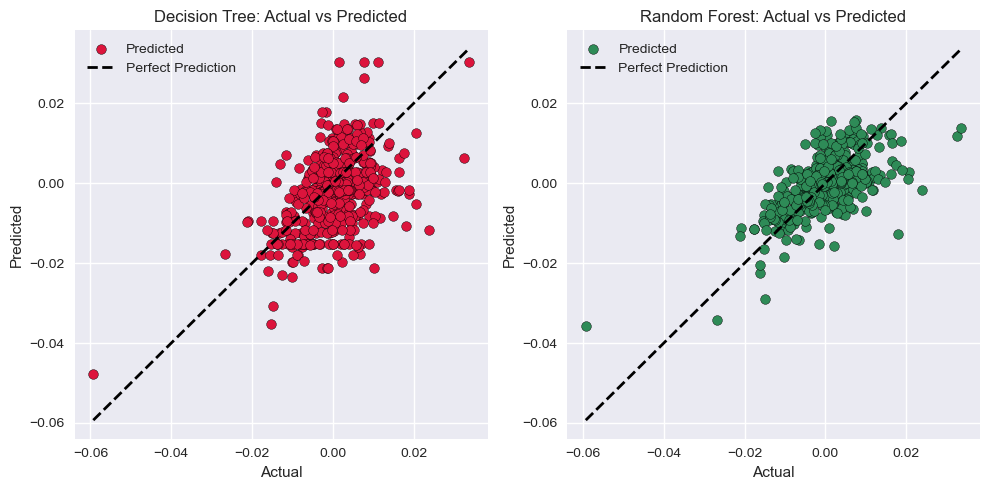

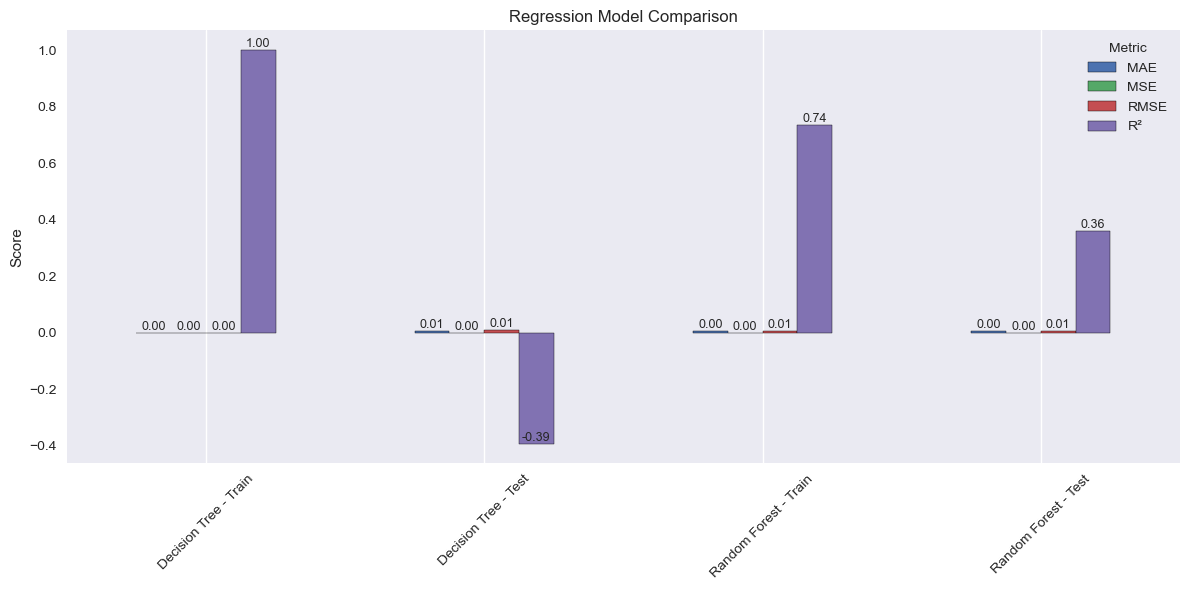

In [3]:

# --- Helper: Calculate Metrics ---
def get_metrics(y_true, y_pred):
    mae = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(y_true, y_pred)
    return [mae, mse, rmse, r2]

# --- Train Models ---
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(x_train.reshape(-1, 12), y_train)
dt_train_pred = dt_model.predict(x_train.reshape(-1, 12))
dt_test_pred = dt_model.predict(x_test.reshape(-1, 12))

rf_model = RandomForestRegressor(n_estimators=100, max_leaf_nodes=64, random_state=42)
rf_model.fit(x_train.reshape(-1, 12), y_train)
rf_train_pred = rf_model.predict(x_train.reshape(-1, 12))
rf_test_pred = rf_model.predict(x_test.reshape(-1, 12))

# --- Evaluate ---
dt_train_metrics = get_metrics(y_train, dt_train_pred)
dt_test_metrics = get_metrics(y_test, dt_test_pred)
rf_train_metrics = get_metrics(y_train, rf_train_pred)
rf_test_metrics = get_metrics(y_test, rf_test_pred)

metrics_df = pd.DataFrame({
    "Metric": ["MAE", "MSE", "RMSE", "R²"],
    "Decision Tree - Train": dt_train_metrics,
    "Decision Tree - Test": dt_test_metrics,
    "Random Forest - Train": rf_train_metrics,
    "Random Forest - Test": rf_test_metrics
})

print("\nModel Performance Comparison:")
print(metrics_df.to_string(index=False))

# # --- Plot Decision Tree ---
# plt.figure(figsize=(12, 6))
# plot_tree(dt_model, filled=True, feature_names=["X"], precision=2)
# plt.title("Decision Tree Regressor Structure")
# plt.show()

# --- Plot Actual vs Predicted ---
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, dt_test_pred, color='crimson', edgecolor='k', label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Decision Tree: Actual vs Predicted')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_test, rf_test_pred, color='seagreen', edgecolor='k', label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest: Actual vs Predicted')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --- Bar Chart: Metrics Comparison ---
bar_df = metrics_df.set_index("Metric").T
ax = bar_df.plot(kind='bar', figsize=(12, 6), legend=True, edgecolor='black')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=9)

plt.title("Regression Model Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [4]:
plot_results(y_test, dt_test_pred, original_label="Actual", pred_label="DT Test Predicted", figsize=(30, 5), filename='dt_test_pred.pdf')
plot_results(y_test, rf_test_pred, original_label="Actual", pred_label="RF Test Predicted", figsize=(30, 5), filename='rf_test_pred.pdf')

Plot saved to /Users/sharmaparth/Codes/Stock_Price_Prediction/Results/Trial/dt_test_pred.pdf
Plot saved to /Users/sharmaparth/Codes/Stock_Price_Prediction/Results/Trial/rf_test_pred.pdf


### Weighted Average

In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split

# Load with backward compatibility
result = load_dataset(option="premade", file_path="/Users/sharmaparth/Codes/Stock_Price_Prediction/dataset/Combined_Main_India_Vix.csv", use_close_as_y=False)
date_v, X, Y, X_train, X_test, y_train, y_test, scaler, close_series, base_price = result

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

# ------------------------------
# 🌲 Train Random Forest
# ------------------------------
rf = RandomForestRegressor(n_estimators=100, max_leaf_nodes=64, random_state=42)
rf.fit(X_train, y_train)

# ------------------------------
# 🔄 Train ARIMAX
# ------------------------------
arimax_model = SARIMAX(endog=y_train, exog=X_train, order=(1, 0, 1),
                       enforce_stationarity=False, enforce_invertibility=False)
arimax_result = arimax_model.fit(disp=False)

# ------------------------------
# 🔁 Step-by-step prediction with dynamic weights
# ------------------------------
window_size = 1  # for RMSE calculation
rf_preds_history = []
arimax_preds_history = []
y_actual_history = []
final_preds = []

for i in range(len(X_test)):
    x_input = X_test[i].reshape(1, -1)

    # Predict next point using RF and ARIMAX
    rf_pred = rf.predict(x_input)[0]
    arimax_pred = arimax_result.forecast(steps=1, exog=x_input)[0]

    # Update prediction history
    rf_preds_history.append(rf_pred)
    arimax_preds_history.append(arimax_pred)
    y_actual_history.append(y_test[i])

    # Calculate rolling RMSE using the last `window_size` predictions
    if len(y_actual_history) >= window_size:
        y_slice = y_actual_history[-window_size:]
        rf_slice = rf_preds_history[-window_size:]
        arimax_slice = arimax_preds_history[-window_size:]

        rmse_rf = mean_absolute_error(y_slice, rf_slice)
        rmse_arimax = mean_absolute_error(y_slice, arimax_slice)

        # rmse_rf = mean_squared_error(y_slice, rf_slice, squared=False)
        # rmse_arimax = mean_squared_error(y_slice, arimax_slice, squared=False)

    
        # Compute inverse RMSE weights
        w_rf = 1 / rmse_rf
        w_arimax = 1 / rmse_arimax
        total_w = w_rf + w_arimax

        w_rf /= total_w
        w_arimax /= total_w
    else:
        # Use equal weights until we have enough history
        w_rf = w_arimax = 0.5

    # Final combined prediction
    combined_pred = w_rf * rf_pred + w_arimax * arimax_pred
    final_preds.append(combined_pred)

# ------------------------------
# 📊 Final Evaluation
# ------------------------------
rmse_rf_final = mean_squared_error(y_test, rf_preds_history, squared=False)
rmse_arimax_final = mean_squared_error(y_test, arimax_preds_history, squared=False)
rmse_combined_final = mean_squared_error(y_test, final_preds, squared=False)

print("📈 Final Step-by-Step Evaluation:")
print(f"RF Test RMSE:      {rmse_rf_final:.7f}")
print(f"ARIMAX Test RMSE:  {rmse_arimax_final:.7f}")
print(f"Combined RMSE:     {rmse_combined_final:.7f}")

plot_results(y_test, final_preds, original_label="Actual", pred_label="RF + ARIMAX Predicted", figsize=(40, 5), filename='rf_Arimax_Comb_test_pred.pdf')

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


📈 Final Step-by-Step Evaluation:
RF Test RMSE:      0.0061356
ARIMAX Test RMSE:  0.0065900
Combined RMSE:     0.0058236
Plot saved to /Users/sharmaparth/Codes/Stock_Price_Prediction/Results/Trial/rf_Arimax_Comb_test_pred.pdf


In [8]:
plot_results(
    data_dict={
        "Actual": (range(len(y_test)), y_test, {"color": "black", "linewidth": 2, "alpha": 0.7}),
        "ARIMA Predictions": (range(len(y_test)), arimax_preds_history, {"color": "green", "linestyle": "--", "alpha": 0.65}),
        "RF Predictions": (range(len(y_test)), rf_preds_history, {"color": "brown", "linestyle": "--", "alpha": 0.65}),
        "Final Predictions": (range(len(y_test)), final_preds, {"color": "blue", "linestyle": "-", "alpha": 0.7})
    },
    title="Actual vs Predicted (ARIMA + LSTM)",
    filename="9_All_Predictions.pdf",
    figsize=(80, 8)
)

Plot saved to /Users/sharmaparth/Codes/Stock_Price_Prediction/Results/Trial/9_All_Predictions.pdf


### MLP Average

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam

# ------------------------------
# Step 1: Split data
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

# ------------------------------
# Step 2: Train Random Forest
# ------------------------------
rf = RandomForestRegressor(n_estimators=100, max_leaf_nodes=64, random_state=42)
rf.fit(X_train, y_train)

rf_preds_train = rf.predict(X_train)
rf_preds_test = rf.predict(X_test)

# ------------------------------
# Step 3: Train ARIMAX
# ------------------------------
arimax_model = SARIMAX(endog=y_train, exog=X_train, order=(1, 0, 1),
                       enforce_stationarity=False, enforce_invertibility=False)
arimax_result = arimax_model.fit(disp=False)

arimax_preds_train = arimax_result.predict(start=0, end=len(y_train)-1, exog=X_train)
arimax_preds_test = arimax_result.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test)

# ------------------------------
# Step 4: MLP Fusion Model (Meta-Learner)
# ------------------------------
# Prepare input to MLP: [RF prediction, ARIMAX prediction]
meta_X_train = np.column_stack((rf_preds_train, arimax_preds_train))
meta_X_test = np.column_stack((rf_preds_test, arimax_preds_test))

# Build MLP using tf.keras.Sequential
mlp_model = Sequential([
    Dense(8, activation='relu', input_shape=(2,)),
    Dense(4, activation='relu'),
    Dense(1)  # Output layer for regression
])

mlp_model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# Train
mlp_model.fit(meta_X_train, y_train, epochs=100, batch_size=16, verbose=1)

# Predict
final_preds = mlp_model.predict(meta_X_test).flatten()

# ------------------------------
# Step 5: Evaluation
# ------------------------------
rmse_rf = mean_squared_error(y_test, rf_preds_test, squared=False)
rmse_arimax = mean_squared_error(y_test, arimax_preds_test, squared=False)
rmse_final = mean_squared_error(y_test, final_preds, squared=False)

print("📊 RMSE on Test Set:")
print(f"RF:        {rmse_rf:.4f}")
print(f"ARIMAX:    {rmse_arimax:.4f}")
print(f"MLP Fusion:{rmse_final:.4f}")

plot_results(y_test, final_preds, original_label="Actual", pred_label="RF + ARIMAX Predicted", figsize=(40, 5), filename='mlp_Comb_test_pred.pdf')



Epoch 1/100


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5202e-04
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.8393e-05
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.9630e-05
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.5036e-05
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.5438e-05
Epoch 6/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1740e-05
Epoch 7/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.3990e-05
Epoch 8/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.3680e-05
Epoch 9/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.7832e-05
Epoch 10/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.2001e-05
Epoch 11/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.6273e-05
Epoch 12/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.9780e-05
Epoch 13/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.7658e-05
Epoch 14/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.0393e-05

In [6]:
mlp_model.save("../models/mlp_average.h5")

### LSTM model average

In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, LSTM, GRU
from tensorflow.keras.optimizers import Adam
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# -------------------------------------
# 📥 Load your dataset
# -------------------------------------
result = load_dataset(option="premade", file_path="../dataset/Combined_Main_India_Vix.csv", use_close_as_y=False)
date_v, X, Y, X_train, X_test, y_train, y_test, scaler, close_series, base_price = result

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

if isinstance(X_train, pd.DataFrame):
    X_train = X_train.values
    X_test = X_test.values

# -----------------------------
# 🎯 Train Base Models
# -----------------------------
xgb = XGBRegressor(n_estimators=75, max_depth=3, learning_rate=0.2,
                   subsample=0.8, colsample_bytree=0.6, random_state=42, verbosity=0)
xgb.fit(X_train, y_train)

lgb = LGBMRegressor(n_estimators=200, max_depth=3, learning_rate=0.1,
                    subsample=0.6, colsample_bytree=0.7,
                    min_child_samples=10, min_data_in_leaf=40, random_state=42)
lgb.fit(X_train, y_train)

cat = CatBoostRegressor(iterations=150, learning_rate=0.1, depth=5, verbose=0, random_seed=42)
cat.fit(X_train, y_train)

arimax_model = SARIMAX(endog=y_train, exog=X_train, order=(1, 0, 1),
                       enforce_stationarity=False, enforce_invertibility=False)
arimax_result = arimax_model.fit(disp=False)

# -----------------------------
# 🌀 Generate MetaNet Input: shape (4, 2)
# -----------------------------
def rolling_mae(y_true_list, pred_list, window=1):
    if len(y_true_list) < window:
        return 0.0
    return mean_absolute_error(y_true_list[-window:], pred_list[-window:])

xgb_preds, lgb_preds, cat_preds, arimax_preds, y_actual = [], [], [], [], []
meta_input_list, meta_target_list = [], []

for i in range(len(X_test)):
    x_input = X_test[i].reshape(1, -1)

    pred_xgb = xgb.predict(x_input)[0]
    pred_lgb = lgb.predict(x_input)[0]
    pred_cat = cat.predict(x_input)[0]
    pred_arimax = arimax_result.forecast(steps=1, exog=x_input)[0]

    xgb_preds.append(pred_xgb)
    lgb_preds.append(pred_lgb)
    cat_preds.append(pred_cat)
    arimax_preds.append(pred_arimax)
    y_actual.append(y_test[i])

    mae_xgb = rolling_mae(y_actual, xgb_preds)
    mae_lgb = rolling_mae(y_actual, lgb_preds)
    mae_cat = rolling_mae(y_actual, cat_preds)
    mae_arimax = rolling_mae(y_actual, arimax_preds)

    # 👇 shape = (4, 2)
    meta_features = np.array([
        [pred_xgb, mae_xgb],
        [pred_lgb, mae_lgb],
        [pred_cat, mae_cat],
        [pred_arimax, mae_arimax]
    ])
    meta_input_list.append(meta_features)
    meta_target_list.append(y_test[i])

X_meta = np.array(meta_input_list)  # shape: (n_samples, 4, 2)
y_meta = np.array(meta_target_list)

# -----------------------------
# 🔧 MetaNet using Flatten-based Feedforward Network
# -----------------------------
model = Sequential([
    Input(shape=(4, 2)),
    LSTM(16, activation='tanh'),  # or GRU(16) if you prefer
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
model.fit(X_meta, y_meta, epochs=200, verbose=0, batch_size=16)

# -----------------------------
# 📈 Evaluate
# -----------------------------
final_preds = model.predict(X_meta).flatten()

rmse_ensemble = np.sqrt(mean_squared_error(y_test, final_preds))
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_preds))
rmse_lgb = np.sqrt(mean_squared_error(y_test, lgb_preds))
rmse_cat = np.sqrt(mean_squared_error(y_test, cat_preds))
rmse_arimax = np.sqrt(mean_squared_error(y_test, arimax_preds))

print("\n📊 Final RMSEs:")
print(f"XGBoost RMSE:   {rmse_xgb:.7f}")
print(f"LightGBM RMSE:  {rmse_lgb:.7f}")
print(f"CatBoost RMSE:  {rmse_cat:.7f}")
print(f"ARIMAX RMSE:    {rmse_arimax:.7f}")
print(f"MetaNet RMSE:   {rmse_ensemble:.7f}")

# -----------------------------
# 📊 Plot Results
# -----------------------------
plot_results(
    y_test,
    final_preds,
    original_label="Actual",
    pred_label="MetaNet Ensemble (4x2 Input)",
    figsize=(40, 5),
    filename='boosting_arimax_metanet_tensorflow_4x2.pdf'
)

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 2126, number of used features: 12
[LightGBM] [Info] Start training from score 0.000536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

In [11]:
# Save the weights
model.save_weights("metanet_lstm.weights.h5")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, LSTM
from tensorflow.keras.optimizers import Adam
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# -------------------------------------
# 📥 Load your dataset
# -------------------------------------
from data_preprocessing import load_dataset, plot_results

result = load_dataset(option="premade", file_path="../dataset/Combined_Main_India_Vix.csv", use_close_as_y=False)
date_v, X, Y, X_train, X_test, y_train, y_test, scaler, close_series, base_price = result

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

if isinstance(X_train, pd.DataFrame):
    X_train = X_train.values
    X_test = X_test.values

# -----------------------------
# 🎯 Train Base Models
# -----------------------------
xgb = XGBRegressor(n_estimators=75, max_depth=3, learning_rate=0.2,
                   subsample=0.8, colsample_bytree=0.6, random_state=42, verbosity=0)
xgb.fit(X_train, y_train)

lgb = LGBMRegressor(n_estimators=200, max_depth=3, learning_rate=0.1,
                    subsample=0.6, colsample_bytree=0.7,
                    min_child_samples=10, min_data_in_leaf=40, random_state=42)
lgb.fit(X_train, y_train)

cat = CatBoostRegressor(iterations=150, learning_rate=0.1, depth=5, verbose=0, random_seed=42)
cat.fit(X_train, y_train)

rf = RandomForestRegressor(n_estimators=100, max_leaf_nodes=64, random_state=42)
rf.fit(X_train, y_train)

arimax_model = SARIMAX(endog=y_train, exog=X_train, order=(1, 0, 1),
                       enforce_stationarity=False, enforce_invertibility=False)
arimax_result = arimax_model.fit(disp=False)

# -----------------------------
# 🌀 Generate MetaNet Input: shape (5, 2)
# -----------------------------
def rolling_mae(y_true_list, pred_list, window=1):
    if len(y_true_list) < window:
        return 0.0
    return mean_absolute_error(y_true_list[-window:], pred_list[-window:])

xgb_preds, lgb_preds, cat_preds, rf_preds, arimax_preds, y_actual = [], [], [], [], [], []
meta_input_list = []
meta_target_list = []

for i in range(len(X_test)):
    x_input = X_test[i].reshape(1, -1)

    pred_xgb = xgb.predict(x_input)[0]
    pred_lgb = lgb.predict(x_input)[0]
    pred_cat = cat.predict(x_input)[0]
    pred_rf = rf.predict(x_input)[0]
    pred_arimax = arimax_result.forecast(steps=1, exog=x_input)[0]

    xgb_preds.append(pred_xgb)
    lgb_preds.append(pred_lgb)
    cat_preds.append(pred_cat)
    rf_preds.append(pred_rf)
    arimax_preds.append(pred_arimax)
    y_actual.append(y_test[i])

    mae_xgb = rolling_mae(y_actual, xgb_preds)
    mae_lgb = rolling_mae(y_actual, lgb_preds)
    mae_cat = rolling_mae(y_actual, cat_preds)
    mae_rf = rolling_mae(y_actual, rf_preds)
    mae_arimax = rolling_mae(y_actual, arimax_preds)

    # 👇 shape = (5, 2)
    meta_features = np.array([
        [pred_xgb, mae_xgb],
        [pred_lgb, mae_lgb],
        [pred_cat, mae_cat],
        [pred_rf, mae_rf],
        [pred_arimax, mae_arimax]
    ])
    meta_input_list.append(meta_features)
    meta_target_list.append(y_test[i])

X_meta = np.array(meta_input_list)  # shape: (n_samples, 5, 2)
y_meta = np.array(meta_target_list)

# -----------------------------
# 🔧 MetaNet using LSTM
# -----------------------------
tf.keras.backend.clear_session()

model = Sequential([
    Input(shape=(5, 2)),
    LSTM(16, activation='tanh'),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
model.fit(X_meta, y_meta, epochs=200, verbose=0, batch_size=16)

# -----------------------------
# 📈 Evaluate
# -----------------------------
final_preds = model.predict(X_meta).flatten()

rmse_ensemble = np.sqrt(mean_squared_error(y_test, final_preds))
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_preds))
rmse_lgb = np.sqrt(mean_squared_error(y_test, lgb_preds))
rmse_cat = np.sqrt(mean_squared_error(y_test, cat_preds))
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_preds))
rmse_arimax = np.sqrt(mean_squared_error(y_test, arimax_preds))

print("\n📊 Final RMSEs:")
print(f"XGBoost RMSE:   {rmse_xgb:.7f}")
print(f"LightGBM RMSE:  {rmse_lgb:.7f}")
print(f"CatBoost RMSE:  {rmse_cat:.7f}")
print(f"RandomForest RMSE: {rmse_rf:.7f}")
print(f"ARIMAX RMSE:    {rmse_arimax:.7f}")
print(f"MetaNet RMSE:   {rmse_ensemble:.7f}")

# -----------------------------
# 📊 Plot Results
# -----------------------------
plot_results(
    y_test,
    final_preds,
    original_label="Actual",
    pred_label="MetaNet Ensemble (5x2 Input)",
    figsize=(40, 5),
    filename='boosting_arimax_rf_metanet_tensorflow_5x2.pdf'
)

ModuleNotFoundError: No module named 'data_preprocessing'

### Train, Val, Test

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import warnings


# from data_preprocessing import load_dataset, plot_results

warnings.filterwarnings("ignore", category=UserWarning)

# ------------------------
# 📥 Load Data
# ------------------------
result = load_dataset(option="premade", file_path="../dataset/Combined_Main_India_Vix.csv", use_close_as_y=False)
date_v, X, Y, _, _, _, _, scaler, _, _ = result

# Convert to numpy if needed
X = X.values if isinstance(X, pd.DataFrame) else X
Y = Y.values if isinstance(Y, pd.Series) else Y

# ------------------------
# 📊 3-Way Split
# ------------------------
X_final_test = X[-115:]
Y_final_test = Y[-115:]

X_remain = X[:-115]
Y_remain = Y[:-115]

X_val = X_remain[-266:]
y_val = Y_remain[-266:]

X_train = X_remain[:-266]
y_train = Y_remain[:-266]

# ------------------------
# 🚀 Train Base Models
# ------------------------
xgb = XGBRegressor(n_estimators=75, max_depth=3, learning_rate=0.2, subsample=0.8, colsample_bytree=0.6, random_state=42, verbosity=0)
xgb.fit(X_train, y_train)

lgb = LGBMRegressor(n_estimators=200, max_depth=3, learning_rate=0.1, subsample=0.6, colsample_bytree=0.7, min_child_samples=10, min_data_in_leaf=40, random_state=42)
lgb.fit(X_train, y_train)

cat = CatBoostRegressor(iterations=150, learning_rate=0.1, depth=5, verbose=0, random_seed=42)
cat.fit(X_train, y_train)

rf = RandomForestRegressor(n_estimators=100, max_leaf_nodes=64, random_state=42)
rf.fit(X_train, y_train)

arimax_model = SARIMAX(endog=y_train, exog=X_train, order=(1, 0, 1), enforce_stationarity=False, enforce_invertibility=False)
arimax_result = arimax_model.fit(disp=False)

# ------------------------
# 🧠 Utility
# ------------------------
def rolling_mae(y_true_list, pred_list):
    # return mean_absolute_error(y_true_list[-1:], pred_list[-1:])
    return (y_true_list[-1] - pred_list[-1])


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 2333, number of used features: 12
[LightGBM] [Info] Start training from score 0.000509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

In [3]:

def generate_meta_features(X_seq, y_seq, base_models, arimax_result):
    xgb, lgb, cat, rf = base_models
    preds_xgb, preds_lgb, preds_cat, preds_rf, preds_arimax, y_actual = [], [], [], [], [], []
    meta_input_list = []
    meta_target_list = []

    for i in range(len(X_seq)):
        x_input = X_seq[i].reshape(1, -1)

        # Compute previous timestep MAE (t error)
        mae_xgb = rolling_mae(y_actual, preds_xgb) if i > 0 else 0
        mae_lgb = rolling_mae(y_actual, preds_lgb) if i > 0 else 0
        mae_cat = rolling_mae(y_actual, preds_cat) if i > 0 else 0
        mae_rf  = rolling_mae(y_actual, preds_rf)  if i > 0 else 0
        mae_arimax = rolling_mae(y_actual, preds_arimax) if i > 0 else 0

        # Predict t+1 values
        pred_xgb = xgb.predict(x_input)[0]
        pred_lgb = lgb.predict(x_input)[0]
        pred_cat = cat.predict(x_input)[0]
        pred_rf  = rf.predict(x_input)[0]
        pred_arimax = arimax_result.forecast(steps=1, exog=x_input)[0]

        # Form meta-features using t+1 prediction and t error
        meta_features = np.array([
            [pred_xgb, mae_xgb],
            [pred_lgb, mae_lgb],
            [pred_cat, mae_cat],
            [pred_rf,  mae_rf],
            [pred_arimax, mae_arimax]
        ])
        meta_input_list.append(meta_features)
        meta_target_list.append(y_seq[i])

        # Append actual and predictions after forming meta-features (important!)
        y_actual.append(y_seq[i])
        preds_xgb.append(pred_xgb)
        preds_lgb.append(pred_lgb)
        preds_cat.append(pred_cat)
        preds_rf.append(pred_rf)
        preds_arimax.append(pred_arimax)

    return np.array(meta_input_list), np.array(meta_target_list)
# ------------------------
# 🏗 Build Meta Datasets
# ------------------------
base_models = (xgb, lgb, cat, rf)

X_meta_train, y_meta_train = generate_meta_features(X_train, y_train, base_models, arimax_result)
X_meta_val, y_meta_val = generate_meta_features(X_val, y_val, base_models, arimax_result)
X_meta_test, y_meta_test = generate_meta_features(X_final_test, Y_final_test, base_models, arimax_result)


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min

In [36]:
# def generate_meta_features_(X_seq, y_seq, base_models, arimax_result):
#     xgb, lgb, cat, rf = base_models
#     preds_xgb, preds_lgb, preds_cat, preds_rf, preds_arimax, y_actual = [], [], [], [], [], []
#     meta_input_list = []
#     meta_target_list = []

#     for i in range(len(X_seq)):
#         x_input = X_seq[i].reshape(1, -1)

#         pred_xgb = xgb.predict(x_input)[0]
#         pred_lgb = lgb.predict(x_input)[0]
#         pred_cat = cat.predict(x_input)[0]
#         pred_rf = rf.predict(x_input)[0]
#         pred_arimax = arimax_result.forecast(steps=1, exog=x_input)[0]

#         preds_xgb.append(pred_xgb)
#         preds_lgb.append(pred_lgb)
#         preds_cat.append(pred_cat)
#         preds_rf.append(pred_rf)
#         preds_arimax.append(pred_arimax)
#         y_actual.append(y_seq[i])

#         mae_xgb = rolling_mae(y_actual, preds_xgb)
#         mae_lgb = rolling_mae(y_actual, preds_lgb)
#         mae_cat = rolling_mae(y_actual, preds_cat)
#         mae_rf = rolling_mae(y_actual, preds_rf)
#         mae_arimax = rolling_mae(y_actual, preds_arimax)

#         meta_features = np.array([
#             [pred_xgb, mae_xgb],
#             [pred_lgb, mae_lgb],
#             [pred_cat, mae_cat],
#             [pred_rf, mae_rf],
#             [pred_arimax, mae_arimax]
#         ])
#         meta_input_list.append(meta_features)
#         meta_target_list.append(y_seq[i])

#     return np.array(meta_input_list), np.array(meta_target_list)

# base_models = (xgb, lgb, cat, rf)

# X_meta_train_, y_meta_train_ = generate_meta_features_(X_train, y_train, base_models, arimax_result)
# X_meta_val_, y_meta_val_ = generate_meta_features_(X_val, y_val, base_models, arimax_result)
# X_meta_test_, y_meta_test_ = generate_meta_features_(X_final_test, Y_final_test, base_models, arimax_result)


2025-05-19 16:28:34.110870: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-05-19 16:28:34.110987: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-19 16:28:34.111008: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1747652314.111450   12382 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1747652314.111602   12382 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/300


2025-05-19 16:28:34.663040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


73/73 - 4s - 53ms/step - loss: 9.1250e-05 - val_loss: 4.7171e-05
Epoch 2/300
73/73 - 3s - 35ms/step - loss: 4.3518e-05 - val_loss: 5.4886e-05
Epoch 3/300
73/73 - 3s - 35ms/step - loss: 4.5525e-05 - val_loss: 7.3626e-05
Epoch 4/300
73/73 - 3s - 34ms/step - loss: 4.1098e-05 - val_loss: 4.7202e-05
Epoch 5/300
73/73 - 3s - 37ms/step - loss: 3.8504e-05 - val_loss: 4.9815e-05
Epoch 6/300
73/73 - 3s - 35ms/step - loss: 3.8516e-05 - val_loss: 4.7424e-05
Epoch 7/300
73/73 - 3s - 35ms/step - loss: 4.6914e-05 - val_loss: 4.7259e-05
Epoch 8/300
73/73 - 3s - 37ms/step - loss: 4.2073e-05 - val_loss: 5.5132e-05
Epoch 9/300
73/73 - 3s - 36ms/step - loss: 3.6925e-05 - val_loss: 4.9566e-05
Epoch 10/300
73/73 - 3s - 35ms/step - loss: 3.7684e-05 - val_loss: 4.7686e-05
Epoch 11/300
73/73 - 3s - 34ms/step - loss: 3.7159e-05 - val_loss: 4.6279e-05
Epoch 12/300
73/73 - 3s - 35ms/step - loss: 4.1760e-05 - val_loss: 6.4773e-05
Epoch 13/300
73/73 - 3s - 35ms/step - loss: 3.8908e-05 - val_loss: 6.7850e-05
Epoch 1

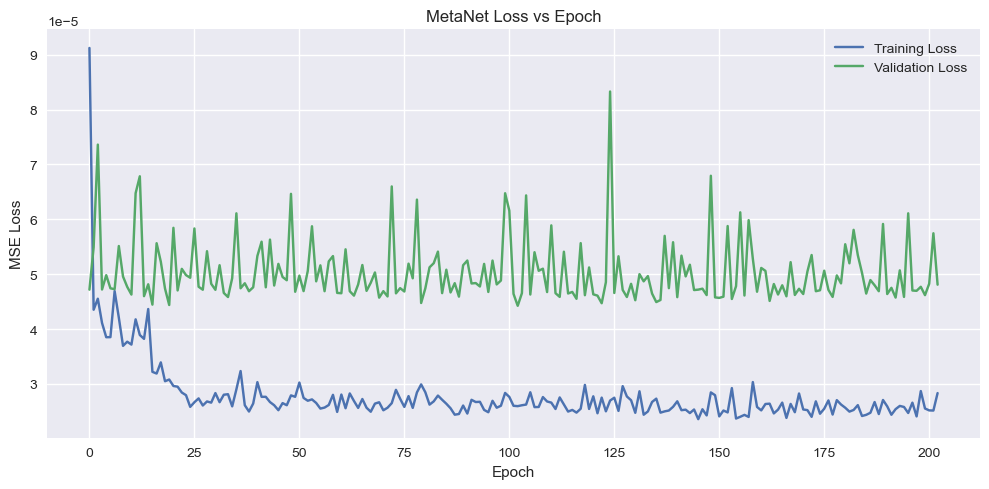

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

✅ MetaNet Validation RMSE: 0.0066507
🧪 MetaNet Final Test RMSE (115 unseen): 0.0064439
Plot saved to ../Results/Trial/metanet_validation_plot__1.pdf
Plot saved to ../Results/Trial/metanet_final_test_plot__1.pdf


In [4]:

# ------------------------
# 📦 Train the MetaNet with history tracking
# ------------------------

tf.keras.backend.clear_session()

# ------------------------
# 🛑 Early Stopping Callback
# ------------------------
early_stopping = EarlyStopping(
    monitor='val_loss',    # Metric to monitor
    patience=100,           # Stop if no improvement for 10 epochs
    restore_best_weights=True,  # Restore model weights from the epoch with the best val_loss
    verbose=1
)

# ------------------------
# 📦 Train the MetaNet with Early Stopping
# ------------------------
model = Sequential([
    Input(shape=(5, 2)),
    LSTM(16, activation='relu'),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

history = model.fit(
    X_meta_train, y_meta_train,
    epochs=300,
    verbose=2,
    batch_size=32,
    validation_data=(X_meta_val, y_meta_val),
    callbacks=[early_stopping]
)

# ------------------------
# 📉 Plot Loss vs Epoch
# ------------------------
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('MetaNet Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../Results/Trial/metanet_loss_plot__1.pdf")
plt.show()

# ------------------------
# 📊 Evaluate
# ------------------------
val_preds = model.predict(X_meta_val).flatten()
test_preds = model.predict(X_meta_test).flatten()

rmse_val = np.sqrt(mean_squared_error(y_meta_val, val_preds))
rmse_test = np.sqrt(mean_squared_error(Y_final_test, test_preds))

print(f"\n✅ MetaNet Validation RMSE: {rmse_val:.7f}")
print(f"🧪 MetaNet Final Test RMSE (115 unseen): {rmse_test:.7f}")

# ------------------------
# 💾 Save model weights
# ------------------------
model.save_weights("../models/metanet_lstm_5_2__1.weights.h5")

# ------------------------
# 📈 Plot Results
# ------------------------
plot_results(
    y_meta_val,
    val_preds,
    original_label="Validation Actual",
    pred_label=f"MetaNet Validation RMSE {rmse_val:.4f}",
    # figsize=(40, 5),
    filename='metanet_validation_plot__1.pdf'
)

plot_results(
    Y_final_test,
    test_preds,
    original_label="Final Test Actual",
    pred_label=f"MetaNet Test RMSE {rmse_test:.4f}",
    # figsize=(40, 5),
    filename='metanet_final_test_plot__1.pdf'
)

# ------------------------
# 📁 Save predictions to CSV
# ------------------------
df_val = pd.DataFrame({
    "y_true": y_meta_val,
    "y_pred": val_preds
})
df_val.to_csv("../Results/Metrics/metanet_validation_preds__1.csv", index=False)

df_test = pd.DataFrame({
    "y_true": Y_final_test,
    "y_pred": test_preds
})
df_test.to_csv("../Results/Metrics/metanet_test_preds__1.csv", index=False)

In [5]:
plot_results(
    history.history['loss'],
    history.history['val_loss'],
    original_label='Training Loss',
    pred_label='Validation Loss',
    # figsize=(40, 5),
    filename='metanet_loss_plot__1.pdf'
)


Plot saved to ../Results/Trial/metanet_loss_plot__1.pdf


In [6]:
from sklearn.metrics import mean_squared_error, r2_score

# ------------------------
# 📊 Evaluate
# ------------------------
val_preds = model.predict(X_meta_val).flatten()
test_preds = model.predict(X_meta_test).flatten()

rmse_val = np.sqrt(mean_squared_error(y_meta_val, val_preds))
rmse_test = np.sqrt(mean_squared_error(Y_final_test, test_preds))

r2_val = r2_score(y_meta_val, val_preds)
r2_test = r2_score(Y_final_test, test_preds)

print(f"\n✅ MetaNet Validation RMSE: {rmse_val:.7f}")
print(f"🔢 MetaNet Validation R²: {r2_val:.7f}")

print(f"🧪 MetaNet Final Test RMSE (115 unseen): {rmse_test:.7f}")
print(f"📈 MetaNet Final Test R² (115 unseen): {r2_test:.7f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

✅ MetaNet Validation RMSE: 0.0066507
🔢 MetaNet Validation R²: 0.3834207
🧪 MetaNet Final Test RMSE (115 unseen): 0.0064439
📈 MetaNet Final Test R² (115 unseen): 0.5130356


In [ ]:
✅ MetaNet Validation RMSE: 0.0066507
🔢 MetaNet Validation R²: 0.3834207
🧪 MetaNet Final Test RMSE (115 unseen): 0.0064439
📈 MetaNet Final Test R² (115 unseen): 0.5130356

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=40


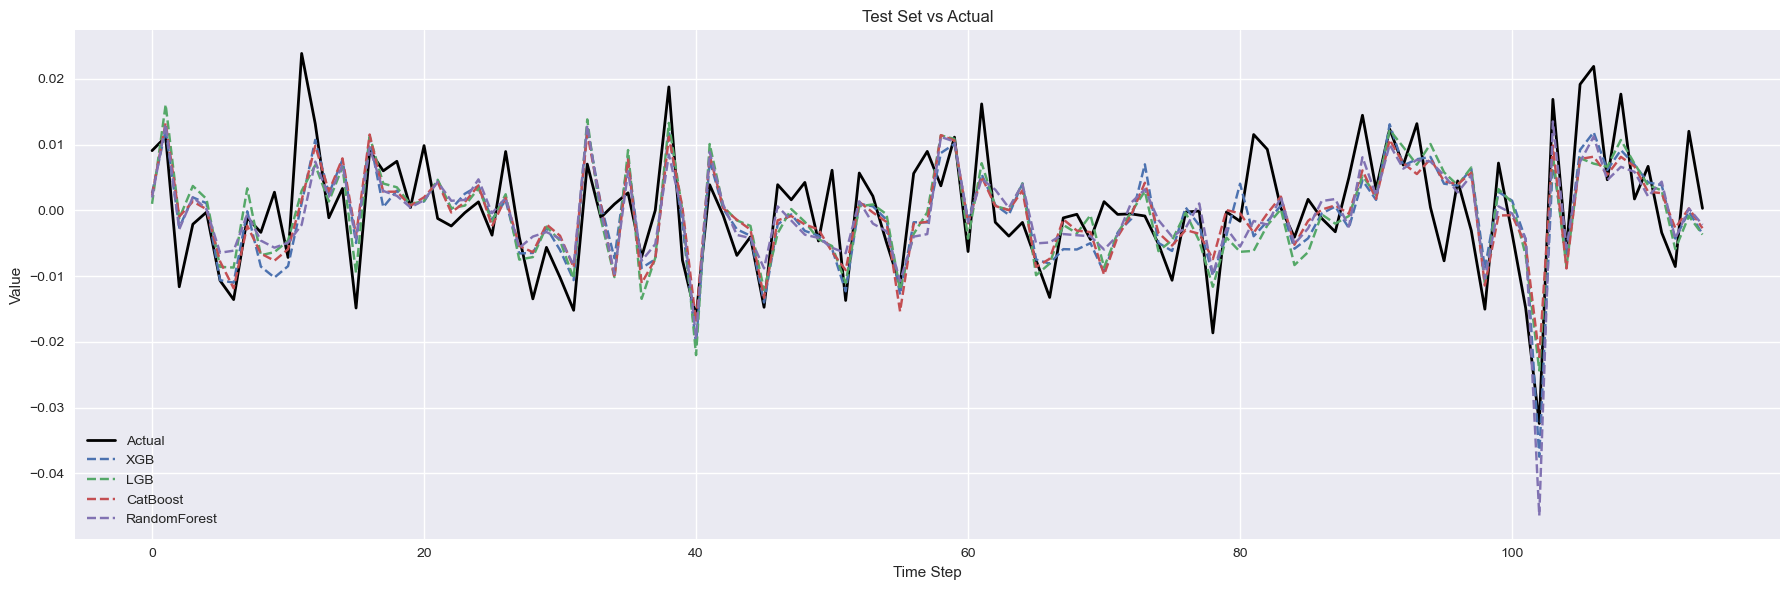

In [32]:
def plot_base_model_predictions(X_seq, y_seq, base_models, model_names=None, title_prefix="Base Model Predictions"):
    if model_names is None:
        model_names = ["XGB", "LGB", "CatBoost", "RandomForest"]

    xgb, lgb, cat, rf = base_models
    models = [xgb, lgb, cat, rf]

    # Flatten input to 2D for each model (n_samples, n_features)
    X_flat = X_seq.reshape((X_seq.shape[0], -1))
    y_true = y_seq

    # Create plot
    plt.figure(figsize=(18, 6))
    plt.plot(y_true, label="Actual", linewidth=2, color='black')

    for model, name in zip(models, model_names):
        y_pred = model.predict(X_flat)
        plt.plot(y_pred, label=name, linestyle='--')

    plt.title(f"{title_prefix} vs Actual")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_base_model_predictions(X_final_test, Y_final_test, base_models, title_prefix="Test Set")

### Python script

In [ ]:
import os
import csv
import numpy as np
import pandas as pd
import warnings
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
# from data_preprocessing import load_dataset, plot_results

warnings.filterwarnings("ignore", category=UserWarning)

# ------------------------
# ⚙️ Config
# ------------------------
train_metanet = True
model_weights_path = "../models/metanet_lstm_5_2.weights.h5"
csv_path = '../Results/Metrics/model_rmse_scores.csv'

# ------------------------
# 📥 Load Data
# ------------------------
result = load_dataset(option="premade", file_path="../dataset/Combined_Main_India_Vix.csv", use_close_as_y=False)
_, X, Y, *_ = result
X, Y = X.values if isinstance(X, pd.DataFrame) else X, Y.values if isinstance(Y, pd.Series) else Y

# 3-way split
X_test, Y_test = X[-115:], Y[-115:]
X_remain, Y_remain = X[:-115], Y[:-115]
X_val, y_val = X_remain[-266:], Y_remain[-266:]
X_train, y_train = X_remain[:-266], Y_remain[:-266:]

# ------------------------
# 🚀 Base Model Training
# ------------------------
def train_base_models(X_train, y_train):
    xgb = XGBRegressor(n_estimators=75, max_depth=3, learning_rate=0.2, subsample=0.8, colsample_bytree=0.6, random_state=42, verbosity=0)
    lgb = LGBMRegressor(n_estimators=200, max_depth=3, learning_rate=0.1, subsample=0.6, colsample_bytree=0.7, min_child_samples=10, min_data_in_leaf=40, random_state=42)
    cat = CatBoostRegressor(iterations=150, learning_rate=0.1, depth=5, verbose=0, random_seed=42)
    rf = RandomForestRegressor(n_estimators=100, max_leaf_nodes=64, random_state=42)

    for model in (xgb, lgb, cat, rf): model.fit(X_train, y_train)
    return xgb, lgb, cat, rf


def rolling_mae(y_true_list, pred_list, window=1):
    return mean_absolute_error(y_true_list[-window:], pred_list[-window:]) if len(y_true_list) >= window else 0.0

def generate_meta_features(X_seq, y_seq, base_models, arimax_result):
    xgb, lgb, cat, rf = base_models
    meta_inputs, meta_targets = [], []

    y_actual = []
    preds = {name: [] for name in ['xgb', 'lgb', 'cat', 'rf', 'arimax']}

    for i in range(len(X_seq)):
        x_input = X_seq[i].reshape(1, -1)
        pred_dict = {
            'xgb': xgb.predict(x_input)[0],
            'lgb': lgb.predict(x_input)[0],
            'cat': cat.predict(x_input)[0],
            'rf': rf.predict(x_input)[0],
            'arimax': arimax_result.forecast(steps=1, exog=x_input)[0]
        }

        for name in pred_dict:
            preds[name].append(pred_dict[name])
        y_actual.append(y_seq[i])

        meta_input = np.array([[pred_dict[name], rolling_mae(y_actual, preds[name])] for name in preds])
        meta_inputs.append(meta_input)
        meta_targets.append(y_seq[i])

    return np.array(meta_inputs), np.array(meta_targets)

# ------------------------
# 🏗 Build Meta Dataset
# ------------------------
base_models = train_base_models(X_train, y_train)
arimax_result = SARIMAX(endog=y_train, exog=X_train, order=(1, 0, 1), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

X_meta_train, y_meta_train = generate_meta_features(X_train, y_train, base_models, arimax_result)
X_meta_val, y_meta_val = generate_meta_features(X_val, y_val, base_models, arimax_result)
X_meta_test, y_meta_test = generate_meta_features(X_test, Y_test, base_models, arimax_result)


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 2333, number of used features: 12
[LightGBM] [Info] Start training from score 0.000509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

In [25]:
model_weights_path = "../models/metanet_lstm_5_2.weights.h5"
train_metanet = True
# ------------------------
# 🧠 MetaNet LSTM Model
# ------------------------
def build_model():
    model = Sequential([
        Input(shape=(5, 2)),
        LSTM(16, activation='relu'),
        # Dense(10),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
    return model

model = build_model()

if train_metanet:
    tf.keras.backend.clear_session()
    model.load_weights(model_weights_path)
    model.fit(X_meta_train, y_meta_train, epochs=300, batch_size=32, verbose=2, validation_data=(X_meta_val, y_meta_val))
    os.makedirs(os.path.dirname(model_weights_path), exist_ok=True)
    model.save_weights(model_weights_path)
else:
    model.load_weights(model_weights_path)

# ------------------------
# 🧪 Evaluation
# ------------------------
val_preds = model.predict(X_meta_val).flatten()
test_preds = model.predict(X_meta_test).flatten()
rmse_val = np.sqrt(mean_squared_error(y_meta_val, val_preds))
rmse_test = np.sqrt(mean_squared_error(Y_test, test_preds))

print(f"\n✅ MetaNet Validation RMSE: {rmse_val:.7f}")
print(f"🧪 MetaNet Final Test RMSE: {rmse_test:.7f}")

# ------------------------
# 💾 Save RMSEs
# ------------------------
rmse_data = [['Model', 'RMSE_Validation', 'RMSE_Test']]

for name, mdl in zip(['XGBoost', 'LightGBM', 'CatBoost', 'RandomForest'], base_models):
    rmse_data.append([name,
        np.sqrt(mean_squared_error(y_val, mdl.predict(X_val))),
        np.sqrt(mean_squared_error(Y_test, mdl.predict(X_test)))
    ])

arimax_val = arimax_result.forecast(steps=len(X_val), exog=X_val)
arimax_test = arimax_result.forecast(steps=len(X_test), exog=X_test)
rmse_data.append(['ARIMAX',
    np.sqrt(mean_squared_error(y_val, arimax_val)),
    np.sqrt(mean_squared_error(Y_test, arimax_test))
])
rmse_data.append(['MetaNet', rmse_val, rmse_test])

os.makedirs(os.path.dirname(csv_path), exist_ok=True)
with open(csv_path, 'w', newline='') as f:
    csv.writer(f).writerows(rmse_data)
print(f"📁 RMSE results saved to: {csv_path}")

# ------------------------
# 📈 Plot Results
# ------------------------
plot_results(
    y_meta_val, val_preds,
    original_label="Validation Actual",
    pred_label=f"MetaNet Validation RMSE {rmse_val:.4f}",
    figsize=(40, 5),
    filename='metanet_validation_plot_s.pdf'
)

plot_results(
    Y_test, test_preds,
    original_label="Final Test Actual",
    pred_label=f"MetaNet Test RMSE {rmse_test:.4f}",
    figsize=(40, 5),
    filename='metanet_final_test_plot_s.pdf'
)

Epoch 1/300
73/73 - 4s - 53ms/step - loss: 9.0953e-05 - val_loss: 1.0174e-04
Epoch 2/300
73/73 - 3s - 35ms/step - loss: 7.0687e-05 - val_loss: 8.5363e-05
Epoch 3/300
73/73 - 3s - 35ms/step - loss: 6.1198e-05 - val_loss: 7.8969e-05
Epoch 4/300
73/73 - 3s - 36ms/step - loss: 5.9431e-05 - val_loss: 7.7562e-05
Epoch 5/300
73/73 - 3s - 35ms/step - loss: 5.4244e-05 - val_loss: 8.3391e-05
Epoch 6/300
73/73 - 3s - 35ms/step - loss: 4.8032e-05 - val_loss: 6.9569e-05
Epoch 7/300
73/73 - 3s - 35ms/step - loss: 4.7376e-05 - val_loss: 6.9552e-05
Epoch 8/300
73/73 - 3s - 37ms/step - loss: 4.5463e-05 - val_loss: 7.0679e-05
Epoch 9/300
73/73 - 3s - 39ms/step - loss: 4.0956e-05 - val_loss: 7.9146e-05
Epoch 10/300
73/73 - 3s - 37ms/step - loss: 3.8739e-05 - val_loss: 6.2560e-05
Epoch 11/300
73/73 - 3s - 35ms/step - loss: 3.5558e-05 - val_loss: 6.0916e-05
Epoch 12/300
73/73 - 3s - 37ms/step - loss: 3.4908e-05 - val_loss: 7.0489e-05
Epoch 13/300
73/73 - 3s - 39ms/step - loss: 3.3519e-05 - val_loss: 7.9122

In [8]:
X_meta_test.shape

(115, 5, 2)

### Boosting algorithms

In [39]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor # type: ignore
from lightgbm import LGBMRegressor # type: ignore
from catboost import CatBoostRegressor # type: ignore
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# -------------------------------------
# 📥 Load your dataset
# -------------------------------------
result = load_dataset(option="premade", file_path="../dataset/Combined_Main_India_Vix.csv", use_close_as_y=False)
date_v, X, Y, X_train, X_test, y_train, y_test, scaler, close_series, base_price = result

# Re-split for robustness
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

# Convert to NumPy arrays to avoid feature name warnings
if isinstance(X_train, pd.DataFrame):
    X_train = X_train.values
    X_test = X_test.values

# -----------------------------
# 🎯 XGBoost Model with Best Hyperparameters
# -----------------------------
xgb = XGBRegressor(
    n_estimators=75,
    max_depth=3,
    learning_rate=0.2,
    subsample=0.8,
    colsample_bytree=0.6,
    random_state=42,
    verbosity=0
)
xgb.fit(X_train, y_train)

# -----------------------------
# 🎯 LightGBM Model with Best Hyperparameters
# -----------------------------
lgb = LGBMRegressor(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.6,
    colsample_bytree=0.7,
    min_child_samples=10,
    min_data_in_leaf=40,
    random_state=42
)
lgb.fit(X_train, y_train)

# -----------------------------
# 🎯 CatBoost Model with Best Hyperparameters
# -----------------------------
cat = CatBoostRegressor(
    iterations=150,
    learning_rate=0.1,
    depth=5,
    verbose=0,
    random_seed=42
)
cat.fit(X_train, y_train)

# -------------------------------------
# 🧠 Train ARIMAX Model
# -------------------------------------
arimax_model = SARIMAX(endog=y_train, exog=X_train, order=(1, 0, 1),
                       enforce_stationarity=False, enforce_invertibility=False)
arimax_result = arimax_model.fit(disp=False)

# -------------------------------------
# 🌀 Dynamic Weighted Ensemble Prediction
# -------------------------------------
window_size = 1  # Rolling window size
xgb_preds, lgb_preds, cat_preds, arimax_preds, y_actual, final_preds = [], [], [], [], [], []

xgb_preds, lgb_preds, cat_preds, arimax_preds = [], [], [], []
y_actual, final_preds = [], []

for i in range(len(X_test)):
    x_input = X_test[i].reshape(1, -1)

    # ---- Step 1: Compute errors from previous predictions (t error) ----
    if len(y_actual) >= window_size:
        y_win = y_actual[-window_size:]
        mae_xgb = mean_absolute_error(y_win, xgb_preds[-window_size:])
        mae_lgb = mean_absolute_error(y_win, lgb_preds[-window_size:])
        mae_cat = mean_absolute_error(y_win, cat_preds[-window_size:])
        mae_arimax = mean_absolute_error(y_win, arimax_preds[-window_size:])

        inv_maes = [1 / mae for mae in [mae_xgb, mae_lgb, mae_cat, mae_arimax]]
        total_inv = sum(inv_maes)
        weights = [w / total_inv for w in inv_maes]
    else:
        weights = [0.25] * 4  # Equal weights if not enough history

    # ---- Step 2: Predict t+1 using models ----
    pred_xgb = xgb.predict(x_input)[0]
    pred_lgb = lgb.predict(x_input)[0]
    pred_cat = cat.predict(x_input)[0]
    pred_arimax = arimax_result.forecast(steps=1, exog=x_input)[0]

    # ---- Step 3: Weighted prediction based on previous step's error ----
    combined_pred = (
        weights[0] * pred_xgb +
        weights[1] * pred_lgb +
        weights[2] * pred_cat +
        weights[3] * pred_arimax
    )
    final_preds.append(combined_pred)

    # ---- Step 4: Store actual & current predictions AFTER weighting ----
    xgb_preds.append(pred_xgb)
    lgb_preds.append(pred_lgb)
    cat_preds.append(pred_cat)
    arimax_preds.append(pred_arimax)
    y_actual.append(y_test[i])

# -------------------------------------
# 📈 Final Evaluation
# -------------------------------------
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_preds))
rmse_lgb = np.sqrt(mean_squared_error(y_test, lgb_preds))
rmse_cat = np.sqrt(mean_squared_error(y_test, cat_preds))
rmse_arimax = np.sqrt(mean_squared_error(y_test, arimax_preds))
rmse_ensemble = np.sqrt(mean_squared_error(y_test, final_preds))

print("📊 Final RMSEs:")
print(f"XGBoost RMSE:   {rmse_xgb:.7f}")
print(f"LightGBM RMSE:  {rmse_lgb:.7f}")
print(f"CatBoost RMSE:  {rmse_cat:.7f}")
print(f"ARIMAX RMSE:    {rmse_arimax:.7f}")
print(f"Ensemble RMSE:  {rmse_ensemble:.7f}")

# -------------------------------------
# 📊 Plot Results
# -------------------------------------
plot_results(
    y_test, final_preds,
    original_label="Actual",
    pred_label="Boosting + ARIMAX Ensemble",
    figsize=(40, 5),
    filename='boosting_arimax_ensemble.pdf'
)

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 2171, number of used features: 12
[LightGBM] [Info] Start training from score 0.000501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

In [41]:
plot_results(
    data_dict={
        "Actual": (range(len(y_test)), y_test, {"color": "black", "linewidth": 2, "alpha": 0.7}),
        "ARIMAX Predictions": (range(len(y_test)), arimax_preds, {"color": "green", "linestyle": "--", "alpha": 0.65}),
        "XGBoost Predictions": (range(len(y_test)), xgb_preds, {"color": "orange", "linestyle": "--", "alpha": 0.65}),
        "LightGBM Predictions": (range(len(y_test)), lgb_preds, {"color": "blue", "linestyle": "--", "alpha": 0.65}),
        "CatBoost Predictions": (range(len(y_test)), cat_preds, {"color": "purple", "linestyle": "--", "alpha": 0.65}),
        "Final Ensemble": (range(len(y_test)), final_preds, {"color": "red", "linestyle": "-", "linewidth": 2, "alpha": 0.9})
    },
    title="Actual vs Model Predictions (ARIMAX + Boosting Ensemble)",
    filename="boosting_all_model_predictions.pdf",
    figsize=(80, 8)
)

Plot saved to ../Results/Trial/boosting_all_model_predictions.pdf


### Random search tuning

In [19]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import randint, uniform

# Assuming X_train and X_test are pandas DataFrames (which would retain feature names)
# If not, we'll convert them to DataFrames as part of the process.

# -----------------------------
# 🎯 XGBoost Hyperparameter Search
# -----------------------------
xgb_model = XGBRegressor(random_state=42, verbosity=0)

xgb_params = {
    "n_estimators": randint(50, 300),
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.2),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4)
}

xgb_search = RandomizedSearchCV(
    xgb_model, param_distributions=xgb_params,
    n_iter=30, cv=3, verbose=1, n_jobs=-1, scoring='neg_mean_squared_error'
)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_

print("\n✅ Best XGBoost Hyperparameters:")
print(xgb_search.best_params_)

# -----------------------------
# 🎯 LightGBM Hyperparameter Search (No warnings)
# -----------------------------
lgb_model = LGBMRegressor(random_state=42, verbose=-1)

lgb_params = {
    "n_estimators": randint(50, 300),
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.2),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "min_child_samples": randint(10, 50),  # Helps prevent warnings for small splits
    "min_data_in_leaf": randint(10, 50)    # Alternative name in some versions
}

# Convert X_train and X_test to pandas DataFrame for consistency with feature names
X_train_df = pd.DataFrame(X_train, columns=[f'feature_{i}' for i in range(X_train.shape[1])])
X_test_df = pd.DataFrame(X_test, columns=[f'feature_{i}' for i in range(X_test.shape[1])])

lgb_search = RandomizedSearchCV(
    lgb_model, param_distributions=lgb_params,
    n_iter=30, cv=3, verbose=1, n_jobs=-1, scoring='neg_mean_squared_error'
)
lgb_search.fit(X_train_df, y_train)
best_lgb = lgb_search.best_estimator_

print("\n✅ Best LightGBM Hyperparameters:")
print(lgb_search.best_params_)

# -----------------------------
# 🎯 CatBoost Hyperparameter Search
# -----------------------------
cat_model = CatBoostRegressor(verbose=0, random_seed=42, allow_writing_files=False)

cat_params = {
    "iterations": randint(50, 300),
    "depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.2)
}

cat_search = RandomizedSearchCV(
    cat_model, param_distributions=cat_params,
    n_iter=30, cv=3, verbose=1, n_jobs=-1, scoring='neg_mean_squared_error'
)
cat_search.fit(X_train_df, y_train)
best_cat = cat_search.best_estimator_

print("\n✅ Best CatBoost Hyperparameters:")
print(cat_search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits

✅ Best XGBoost Hyperparameters:
{'colsample_bytree': 0.6926471959964964, 'learning_rate': 0.09304580718481413, 'max_depth': 3, 'n_estimators': 136, 'subsample': 0.8721560767278284}
Fitting 3 folds for each of 30 candidates, totalling 90 fits

✅ Best LightGBM Hyperparameters:
{'colsample_bytree': 0.9346843906414664, 'learning_rate': 0.08530586270160498, 'max_depth': 8, 'min_child_samples': 49, 'min_data_in_leaf': 40, 'n_estimators': 92, 'subsample': 0.8048856198900278}
Fitting 3 folds for each of 30 candidates, totalling 90 fits

✅ Best CatBoost Hyperparameters:
{'depth': 4, 'iterations': 96, 'learning_rate': 0.1500469621874683}


### Grid Search tuning

In [20]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd  # Added to ensure DataFrame conversion

# -----------------------------
# 🎯 XGBoost Hyperparameter Search using GridSearchCV
# -----------------------------
xgb_model = XGBRegressor(random_state=42, verbosity=0)

xgb_params = {
    "n_estimators": [50, 75, 100, 150, 200],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.7, 0.8, 0.9],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9]
}

xgb_search = GridSearchCV(
    xgb_model, param_grid=xgb_params,
    cv=3, verbose=1, n_jobs=-1, scoring='neg_mean_squared_error'
)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_

print("\n✅ Best XGBoost Hyperparameters:")
print(xgb_search.best_params_)

# -----------------------------
# 🎯 LightGBM Hyperparameter Search using GridSearchCV
# -----------------------------
lgb_model = LGBMRegressor(random_state=42, verbose=-1)

lgb_params = {
    "n_estimators": [50, 75, 100, 150, 200],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.7, 0.8, 0.9],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9],
    "min_child_samples": [10, 20, 30, 40, 50],
    "min_data_in_leaf": [10, 20, 30, 40, 50]
}

# Convert X_train to DataFrame for consistency with feature names
X_train_df = pd.DataFrame(X_train, columns=[f'feature_{i}' for i in range(X_train.shape[1])])

lgb_search = GridSearchCV(
    lgb_model, param_grid=lgb_params,
    cv=3, verbose=1, n_jobs=-1, scoring='neg_mean_squared_error'
)
lgb_search.fit(X_train_df, y_train)
best_lgb = lgb_search.best_estimator_

print("\n✅ Best LightGBM Hyperparameters:")
print(lgb_search.best_params_)

# -----------------------------
# 🎯 CatBoost Hyperparameter Search using GridSearchCV
# -----------------------------
cat_model = CatBoostRegressor(verbose=0, random_seed=42, allow_writing_files=False)

cat_params = {
    "iterations": [50, 75, 100, 150, 200],
    "depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2]
}

cat_search = GridSearchCV(
    cat_model, param_grid=cat_params,
    cv=3, verbose=1, n_jobs=-1, scoring='neg_mean_squared_error'
)
cat_search.fit(X_train_df, y_train)
best_cat = cat_search.best_estimator_

print("\n✅ Best CatBoost Hyperparameters:")
print(cat_search.best_params_)

Fitting 3 folds for each of 1280 candidates, totalling 3840 fits

✅ Best XGBoost Hyperparameters:
{'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 75, 'subsample': 0.8}
Fitting 3 folds for each of 32000 candidates, totalling 96000 fits

✅ Best LightGBM Hyperparameters:
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 10, 'min_data_in_leaf': 40, 'n_estimators': 200, 'subsample': 0.6}
Fitting 3 folds for each of 80 candidates, totalling 240 fits

✅ Best CatBoost Hyperparameters:
{'depth': 5, 'iterations': 150, 'learning_rate': 0.1}


## RAGIC

In [7]:
import tensorflow as tf
from keras import layers, models, optimizers, losses
import numpy as np
from sklearn.model_selection import train_test_split

# Assumed preloaded variables
# x_train: (2332, 60, 12)
# y_train: (2332,)
# x_test, y_test

SEQ_LEN = 60
FEATURE_DIM = 12
NOISE_DIM = 8
BATCH_SIZE = 16
EPOCHS = 5
ALPHA = 0.1  # Coverage penalty weight



# Assume X shape: (2658, 12), Y shape: (2658,)
def create_sequences(X, Y, seq_len=60):
    x_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        x_seq.append(X[i:i+seq_len])
        y_seq.append(Y[i+seq_len])  # predict next step
    return np.array(x_seq), np.array(y_seq)

# Generate sequences
x_seq, y_seq = create_sequences(X, Y, seq_len=SEQ_LEN)

# Split train/test — same sizes as before
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(
    x_seq, y_seq, test_size=266, shuffle=False  # Keep time order
)

print("x_train_new:", x_train_new.shape)
print("x_test_new:", x_test_new.shape)
print("y_train_new:", y_train_new.shape)
print("y_test_new:", y_test_new.shape)

# Reshape Y if needed
if len(y_train.shape) == 1:
    y_train = y_train.reshape(-1, 1)
if len(y_test.shape) == 1:
    y_test = y_test.reshape(-1, 1)

# Predictor: LSTM → Dense
def build_predictor():
    model = tf.keras.Sequential([
        layers.Input(shape=(SEQ_LEN, FEATURE_DIM)),
        layers.GRU(64),
        layers.Dense(1)
    ])
    return model

# Generator: (x, y_pred, noise) → [lower, upper]
def build_generator():
    x_input = layers.Input(shape=(SEQ_LEN, FEATURE_DIM))
    y_pred_input = layers.Input(shape=(1,))
    noise_input = layers.Input(shape=(NOISE_DIM,))

    x_flat = layers.Flatten()(x_input)
    merged = layers.Concatenate()([x_flat, y_pred_input, noise_input])
    x = layers.Dense(128, activation='relu')(merged)
    out = layers.Dense(2)(x)  # lower and upper bounds
    return models.Model([x_input, y_pred_input, noise_input], out)

# Discriminator: (x, y_pred, [lower, upper]) → real/fake
def build_discriminator():
    x_input = layers.Input(shape=(SEQ_LEN, FEATURE_DIM))
    y_pred_input = layers.Input(shape=(1,))
    interval_input = layers.Input(shape=(2,))

    x_flat = layers.Flatten()(x_input)
    merged = layers.Concatenate()([x_flat, y_pred_input, interval_input])
    x = layers.Dense(128, activation='relu')(merged)
    out = layers.Dense(1, activation='sigmoid')(x)
    return models.Model([x_input, y_pred_input, interval_input], out)

# TF dataset loader
def create_dataset(x, y):
    return tf.data.Dataset.from_tensor_slices((x, y)).shuffle(1024).batch(BATCH_SIZE)

# Build models
predictor = build_predictor()
generator = build_generator()
discriminator = build_discriminator()

# Optimizers
opt_P = optimizers.Adam(1e-3)
opt_G = optimizers.Adam(1e-3)
opt_D = optimizers.Adam(1e-3)

mse = losses.MeanSquaredError()
bce = losses.BinaryCrossentropy()

# Prepare dataset
train_ds = create_dataset(x_train, y_train)


x_train_new: (2388, 60, 12)
x_test_new: (266, 60, 12)
y_train_new: (2388,)
y_test_new: (266,)


ValueError: Dimensions 2388 and 2333 are not compatible

In [ ]:
##### Kernel crash after 9~10 epochs


# for epoch in range(EPOCHS):
#     for step, (xb, yb) in enumerate(train_ds):
#         # Ensure float32 and correct shape
#         xb = tf.cast(xb, tf.float32)
#         yb = tf.reshape(tf.cast(yb, tf.float32), (-1, 1))  # (batch, 1)

#         bs = tf.shape(xb)[0]
#         noise = tf.random.normal((bs, NOISE_DIM), dtype=tf.float32)

#         # === Train Predictor ===
#         with tf.GradientTape() as tape_p:
#             y_pred = predictor(xb, training=True)
#             loss_p = mse(yb, y_pred)
#         grads_p = tape_p.gradient(loss_p, predictor.trainable_weights)
#         opt_P.apply_gradients(zip(grads_p, predictor.trainable_weights))

#         # === Train Discriminator ===
#         with tf.GradientTape() as tape_d:
#             y_pred = predictor(xb, training=False)
#             fake_interval = generator([xb, y_pred, noise], training=True)

#             real_interval = tf.concat([yb - 0.01, yb + 0.01], axis=1)
#             d_real = discriminator([xb, y_pred, real_interval], training=True)
#             d_fake = discriminator([xb, y_pred, fake_interval], training=True)

#             loss_d_real = bce(tf.ones_like(d_real), d_real)
#             loss_d_fake = bce(tf.zeros_like(d_fake), d_fake)
#             loss_d = loss_d_real + loss_d_fake
#         grads_d = tape_d.gradient(loss_d, discriminator.trainable_weights)
#         opt_D.apply_gradients(zip(grads_d, discriminator.trainable_weights))

#         # === Train Generator ===
#         with tf.GradientTape() as tape_g:
#             y_pred = predictor(xb, training=False)
#             fake_interval = generator([xb, y_pred, noise], training=True)
#             d_fake = discriminator([xb, y_pred, fake_interval], training=False)

#             lower = tf.cast(fake_interval[:, 0:1], tf.float32)
#             upper = tf.cast(fake_interval[:, 1:2], tf.float32)

#             coverage_penalty = tf.reduce_mean(tf.cast((yb < lower) | (yb > upper), tf.float32))
#             loss_g = bce(tf.ones_like(d_fake), d_fake) + ALPHA * coverage_penalty
#         grads_g = tape_g.gradient(loss_g, generator.trainable_weights)
#         opt_G.apply_gradients(zip(grads_g, generator.trainable_weights))

#         # Debug: check for NaNs or infs
#         if tf.math.reduce_any(tf.math.is_nan(loss_p)) or tf.math.reduce_any(tf.math.is_inf(loss_p)):
#             print(f"NaN detected in predictor loss at step {step}")
#             break

#     print(f"[{epoch+1:02d}] Predictor: {loss_p.numpy():.8f}, D: {loss_d.numpy():.8f}, G: {loss_g.numpy():.8f}")

: 

In [ ]:
# Initialize lists to track loss
predictor_loss_list = []
discriminator_loss_list = []
generator_loss_list = []

for epoch in range(EPOCHS):
    epoch_p_loss = []
    epoch_d_loss = []
    epoch_g_loss = []

    for step, (xb, yb) in enumerate(train_ds):
        xb = tf.cast(xb, tf.float32)
        yb = tf.cast(tf.reshape(yb, (-1, 1)), tf.float32)
        noise = tf.random.normal((tf.shape(xb)[0], NOISE_DIM), dtype=tf.float32)

        # === Train Predictor ===
        with tf.GradientTape() as tape_p:
            y_pred = predictor(xb, training=True)
            loss_p_val = mse(yb, y_pred)
        grads_p = tape_p.gradient(loss_p_val, predictor.trainable_variables)
        opt_P.apply_gradients(zip(grads_p, predictor.trainable_variables))
        epoch_p_loss.append(loss_p_val.numpy())

        # === Reuse y_pred for D and G
        fake_interval = generator([xb, y_pred, noise], training=True)
        real_interval = tf.concat([yb - 0.01, yb + 0.01], axis=1)

        with tf.GradientTape() as tape_d:
            d_real = discriminator([xb, y_pred, real_interval], training=True)
            d_fake = discriminator([xb, y_pred, fake_interval], training=True)
            loss_d_val = bce(tf.ones_like(d_real), d_real) + bce(tf.zeros_like(d_fake), d_fake)
        grads_d = tape_d.gradient(loss_d_val, discriminator.trainable_variables)
        opt_D.apply_gradients(zip(grads_d, discriminator.trainable_variables))
        epoch_d_loss.append(loss_d_val.numpy())

        with tf.GradientTape() as tape_g:
            fake_interval = generator([xb, y_pred, noise], training=True)
            d_fake = discriminator([xb, y_pred, fake_interval], training=False)
            lower = fake_interval[:, 0:1]
            upper = fake_interval[:, 1:2]
            penalty = tf.cast((yb < lower) | (yb > upper), tf.float32)
            coverage_penalty = tf.reduce_mean(penalty)
            loss_g_val = bce(tf.ones_like(d_fake), d_fake) + ALPHA * coverage_penalty
        grads_g = tape_g.gradient(loss_g_val, generator.trainable_variables)
        opt_G.apply_gradients(zip(grads_g, generator.trainable_variables))
        epoch_g_loss.append(loss_g_val.numpy())

    # Save epoch-wise mean loss
    predictor_loss_list.append(np.mean(epoch_p_loss))
    discriminator_loss_list.append(np.mean(epoch_d_loss))
    generator_loss_list.append(np.mean(epoch_g_loss))

    print(f"[{epoch+1:02d}] Predictor: {np.mean(epoch_p_loss):.7f}, D: {np.mean(epoch_d_loss):.7f}, G: {np.mean(epoch_g_loss):.7f}")

2025-05-08 09:23:53.722444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[01] Predictor: 0.0001, D: 1.4108, G: 0.7735


2025-05-08 09:24:05.778579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[02] Predictor: 0.0001, D: 1.4035, G: 0.7685


2025-05-08 09:24:17.264624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[03] Predictor: 0.0001, D: 1.4092, G: 0.7963


2025-05-08 09:24:29.946677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[04] Predictor: 0.0001, D: 1.3901, G: 0.7845
[05] Predictor: 0.0001, D: 1.3980, G: 0.7783


2025-05-08 09:24:41.605537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


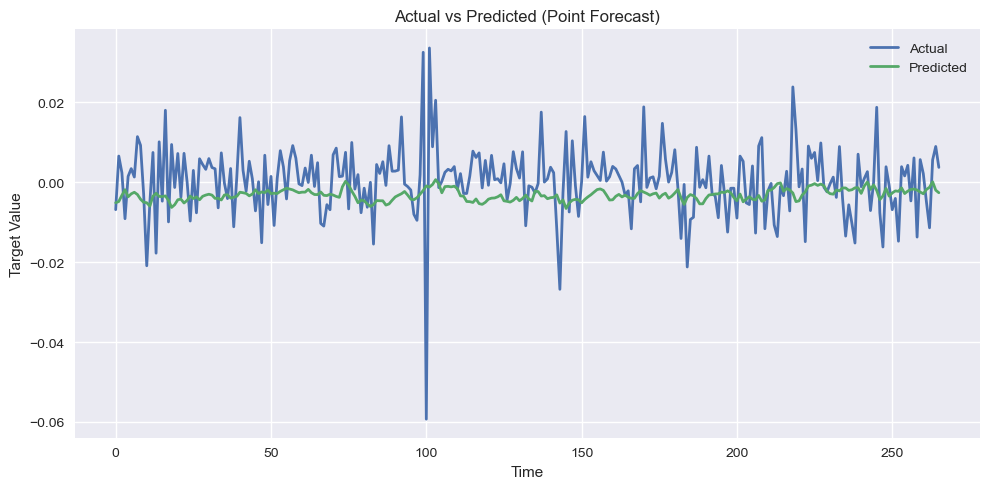

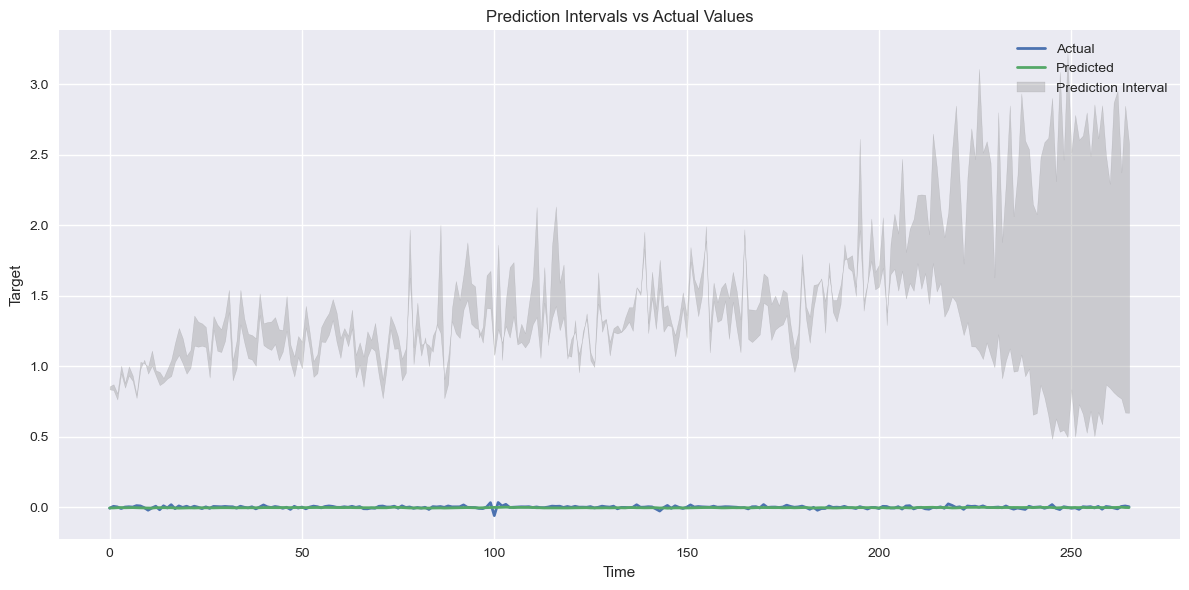

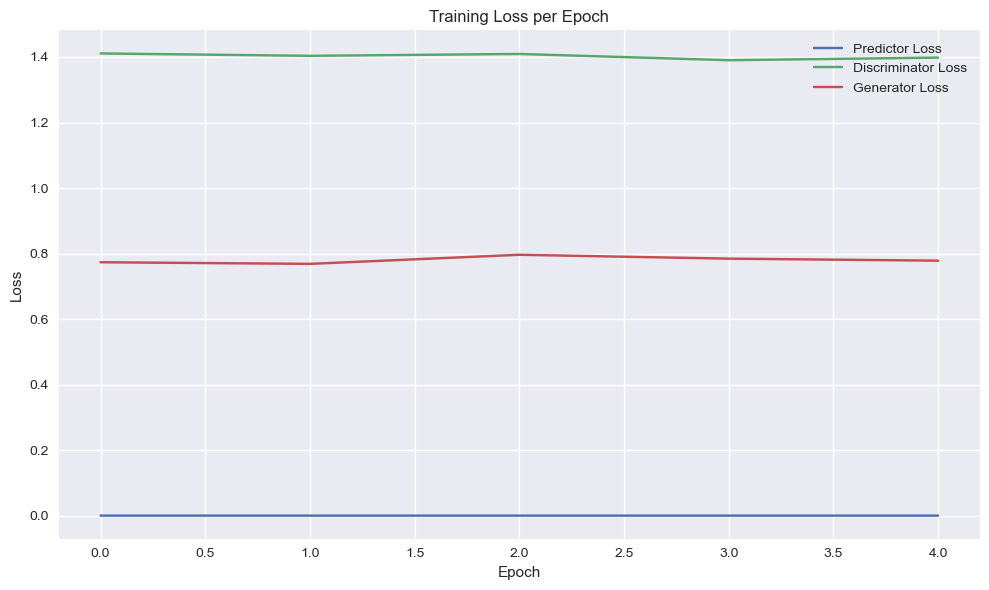

PICP (Coverage Probability): 0.0000
MPIW (Interval Width): 0.2963


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Convert test data
x_test_tf = tf.convert_to_tensor(x_test_new, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test_new.reshape(-1, 1), dtype=tf.float32)

# Predictor point forecasts
y_pred_test = predictor(x_test_tf, training=False).numpy()

# Generator intervals
noise = tf.random.normal((x_test_tf.shape[0], NOISE_DIM), dtype=tf.float32)
interval_bounds = generator([x_test_tf, predictor(x_test_tf), noise], training=False)

lower = interval_bounds[:, 0].numpy()
upper = interval_bounds[:, 1].numpy()
y_true = y_test_new.flatten()
y_point = y_pred_test.flatten()

# 1. Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(y_true, label="Actual", linewidth=2)
plt.plot(y_point, label="Predicted", linewidth=2)
plt.title("Actual vs Predicted (Point Forecast)")
plt.xlabel("Time")
plt.ylabel("Target Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Interval Plot
plt.figure(figsize=(12, 6))
plt.plot(y_true, label="Actual", linewidth=2)
plt.plot(y_point, label="Predicted", linewidth=2)
plt.fill_between(np.arange(len(y_true)), lower, upper, color='gray', alpha=0.3, label="Prediction Interval")
plt.title("Prediction Intervals vs Actual Values")
plt.xlabel("Time")
plt.ylabel("Target")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Loss vs Epoch
plt.figure(figsize=(10, 6))
plt.plot(predictor_loss_list, label="Predictor Loss")
plt.plot(discriminator_loss_list, label="Discriminator Loss")
plt.plot(generator_loss_list, label="Generator Loss")
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Coverage Metrics (PICP & MPIW)
in_interval = (y_true >= lower) & (y_true <= upper)
picp = np.mean(in_interval)
mpiw = np.mean(upper - lower)
print(f"PICP (Coverage Probability): {picp:.4f}")
print(f"MPIW (Interval Width): {mpiw:.4f}")